<center>
<h1> SOLUCIÓN TAREA 2</h1>
<h3>Diego Godoy Rojas & Luis Carlos Diaz </h3>
</center>

In [789]:
#IMPORTAR LIBRERIAS
import cv2
from IPython.display import Image
import numpy as np
from matplotlib import pyplot as plt
from scipy.fftpack import dct, idct
from scipy.fftpack import dst, idst
import pywt
from scipy.ndimage import maximum_filter, minimum_filter, median_filter

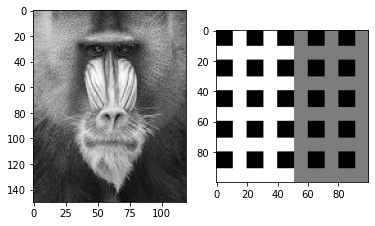

In [790]:
img_f = cv2.imread('fig/img3.jpg',0)
img_s = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        if i%20>10 or j%20>10:
            img_s[i, j] = 255
            if j>50:
                img_s[i, j] = 125
plt.figure(1)
plt.subplot(121).imshow(img_f,cmap='gray')
plt.subplot(122).imshow(img_s,cmap='gray')

<h2>PRIMER PUNTO</h2>

Se implemento la transformada de Hartley para señales bidimensionales:
$$
F(u,v)=\frac{1}{\sqrt{NM}}\sum_{x=0}^{N-1}\sum_{y=0}^{M-1}f(x,y)[cos(a+b)+sen(a+b)]
$$
Donde:
$$
a=\frac{2\pi ux}{N} \ \ \ \ b=\frac{2\pi vy}{M}
$$

In [792]:
def Hartley_T(input):
    X = np.zeros((input.shape))
    [x,y] = np.mgrid[0:input.shape[0], 0:input.shape[1]]
    x_c = 2*np.pi*x/input.shape[0]
    y_c = 2*np.pi*y/input.shape[1]
    for u in range(input.shape[0]):
        a = u*x_c
        for v in range(input.shape[1]):
            b = v*y_c
            temp = np.array(input*(np.cos(a+b) + np.sin(a+b)))
            X[u,v] = temp.sum()/np.sqrt(input.shape[0]*input.shape[1])
            if X[u,v]!=0:
                X[u,v] = 20*np.log(np.absolute(X[u,v]))              
    return X

In [793]:
Digital=Hartley_T(img_f)
Sintetica=Hartley_T(img_s)

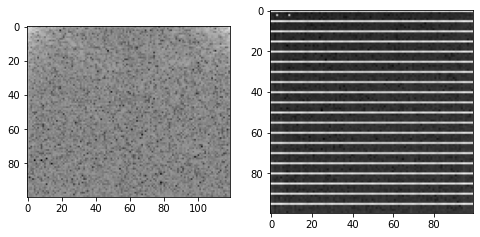

In [796]:
plt.figure(1, figsize=[8,8])
plt.subplot(121).imshow(Digital[0:round(X.shape[0]/2),0:round(X.shape[1]/2)],cmap='gray')
plt.subplot(122).imshow(Sintetica,cmap='gray')

<h2>SEGUNDO PUNTO</h2>
<p>Para esturdiar el rendimiento de las transformadas en la compresión de imágenes se emplean tres tipos diferente, una imágen dígital, una real y una sintética</p>

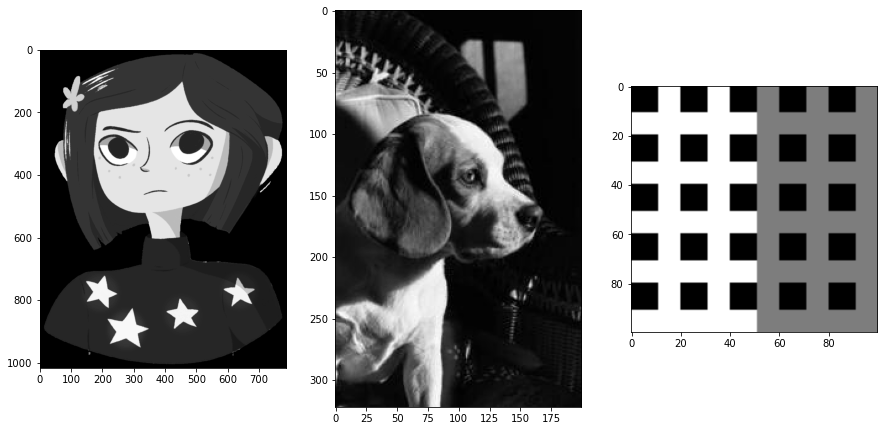

In [788]:
img = cv2.imread('fig/fig.png',0)
img1 = cv2.imread('fig/img2.jpg',0)
img2 = np.zeros([100,100])

for i in range(100):
    for j in range(100):
        if i%20>10 or j%20>10:
            img2[i, j] = 255
            if j>50:
                img2[i, j] = 125

plt.figure(1,figsize=[15, 15])
plt.subplot(131).imshow(img, cmap=plt.cm.gray)
plt.subplot(132).imshow(img1, cmap=plt.cm.gray)
plt.subplot(133).imshow(img2, cmap=plt.cm.gray)

Basado en las funciones predefinidas de la biblioteca Scipy se definen las transformadas Seno y Coseno en dos dimensiones.

In [618]:
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')
def dst2(block):
    return dst(dst(block.T, norm='ortho').T, norm='ortho')
def idst2(block):
    return idst(idst(block.T, norm='ortho').T, norm='ortho')

El algoritmo usado para la compresión consiste en cambiar de dominio la información y truncarla tomando solo aquellos terminos más relevantes.

In [619]:
def compression(input, type, cmprRate):
    # input:     Datos de entrada
    # type:      Transformación: Transformada discreta del coseno   "dct"
    #                            Transformada discreta del seno     "dst"
    #                            Transformada rápida de Fourier     "fft"
    #                            Transformada discreta onditas      "dwt"
    # cmprRat    Razón de compresión: 
    #                            Cantidad de información conservada [0,1]
    #                            1 significa conservar la image original
    
    # Transformación
    if type=="dct":
        inT = dct2(input)
    elif type=="dst":
        inT = dst2(input)
    elif type=="fft":
        inT = np.fft.fft2(input)
    elif type=="dwt":
        coeffs = pywt.wavedec2(input, wavelet='db1', level=4)
        inT, coeff_slices = pywt.coeffs_to_array(coeffs)
    else:
        inT = np.fft.fft2(input)
        
    # Selección del  porcentaje de coeficientes mas significativos según la
    # razón de comresión
    inTSort = np.sort(np.abs(inT.reshape(-1)))
    lowVal = inTSort[int(np.floor((1-cmprRate)*len(inTSort)))]
    mask = np.abs(inT)>lowVal
    
    # Retorno de los coeficientes seleccionados con la mascara
    if type !="dwt":
        return inT*mask
    else:
        return pywt.array_to_coeffs(inT*mask, coeff_slices,output_format='wavedec2')

def decompression(input, type):
    # input:     Datos de entrada
    # type:      Transformación: Transformada discreta del coseno   "dct"
    #                            Transformada discreta del seno     "dst"
    #                            Transformada rápida de Fourier     "fft"
    #                            Transformada discreta onditas      "dwt"
    #
    # Realiza la transformada inversa correspondiente al tipo de compresión
    if type=="dct":
        return idct2(input)
    if type=="dst":
        return idst2(input)
    if type=="fft":
        return np.abs(np.fft.ifft2(input))
    if type=="dwt":
        return pywt.waverec2(input, 'db1')

Para comprobar las funciones se usa la imágen digital. En este caso se conserva el 0.4% de la información y se puede ver que la mejor calidad la tiene la transformada onditas ya que no introduce ruido a la imágen con la desventaja de que los bordes tienen el efecto diente de sierra, por otro las demas transformadas muestran bordes suavizados coherentes con la imagen original pero añaden ruido. Finalmente la transformada de Fourier conserva mejor los colores solidos de la imágen.

Text(0.5, 1.0, 'Transformada onditas')

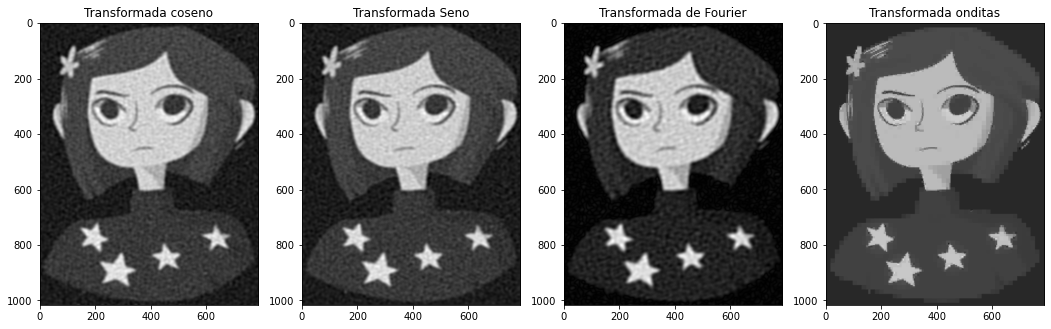

In [643]:
size=18
rate=0.004
image=img
plt.figure(1,figsize=[size, size])
plt.subplot(241).imshow(decompression(compression(image, "dct", rate),"dct"), cmap=plt.cm.gray)
plt.title("Transformada coseno")
plt.subplot(242).imshow(decompression(compression(image, "dst", rate),"dst"), cmap=plt.cm.gray)
plt.title("Transformada Seno")
plt.subplot(243).imshow(decompression(compression(image, "fft", rate),"fft"), cmap=plt.cm.gray)
plt.title("Transformada de Fourier")
plt.subplot(244).imshow(decompression(compression(image, "dwt", rate),"dwt"), cmap=plt.cm.gray)
plt.title("Transformada onditas")

Al usar una imágen real se debe conservar más información de tal manera que la reconstrucción sea aceptable, en este caso se conserva un 2% de los coeficientes mas relevantes. En general las transformadas tienen el mismo comportamiento, la transformada onditas muestra un pixelado importante, a diferencia de las demás que añaden ruido. En todas como es de esperarse se pierden los detalles de la imágen.

Text(0.5, 1.0, 'Transformada onditas')

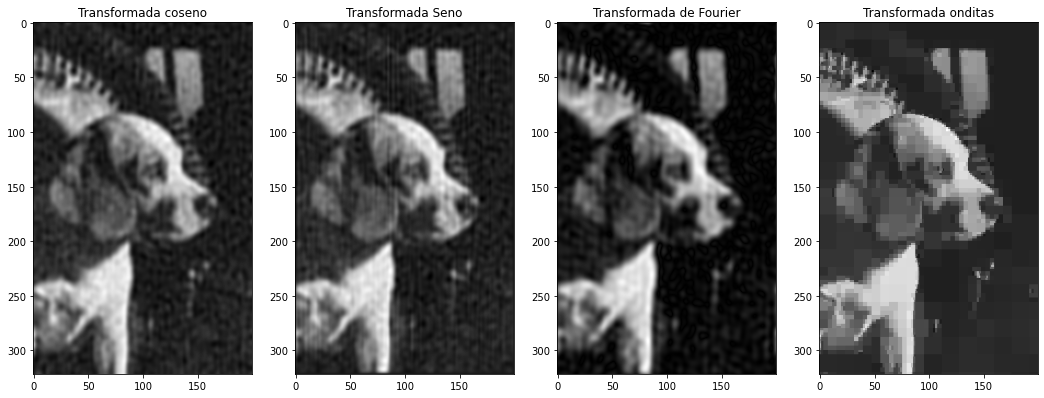

In [644]:
size=18
rate=0.02
image=img1
plt.figure(1,figsize=[size, size])
plt.subplot(241).imshow(decompression(compression(image, "dct", rate),"dct"), cmap=plt.cm.gray)
plt.title("Transformada coseno")
plt.subplot(242).imshow(decompression(compression(image, "dst", rate),"dst"), cmap=plt.cm.gray)
plt.title("Transformada Seno")
plt.subplot(243).imshow(decompression(compression(image, "fft", rate),"fft"), cmap=plt.cm.gray)
plt.title("Transformada de Fourier")
plt.subplot(244).imshow(decompression(compression(image, "dwt", rate),"dwt"), cmap=plt.cm.gray)
plt.title("Transformada onditas")

Al usar las funciones con la imágen sintética generada anteriormente se conserva el 0.8% de la información. En este caso el mejor rendimiento lo tiene la transformada de Fourier que muestra bordes bien definidos pero añade lineas que no están en la imágen original, por otro lado las transformadas seno y coseno muestran una imágen borrosa pero se pueden distiguir los elementos. La transformada Onditas cambia la imágen original casi por completo y muestra colores solidos y bordes bien definidos, que tienen alguna coherencia con la imagen original.

Text(0.5, 1.0, 'Transformada onditas')

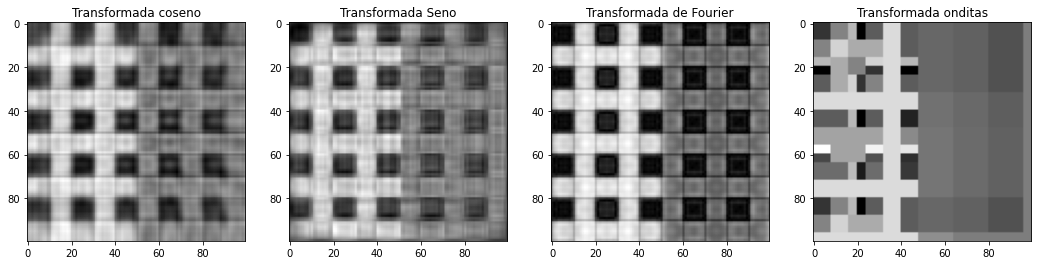

In [645]:
size=18
rate=0.008
image=img2
plt.figure(1,figsize=[size, size])
plt.subplot(241).imshow(decompression(compression(image, "dct", rate),"dct"), cmap=plt.cm.gray)
plt.title("Transformada coseno")
plt.subplot(242).imshow(decompression(compression(image, "dst", rate),"dst"), cmap=plt.cm.gray)
plt.title("Transformada Seno")
plt.subplot(243).imshow(decompression(compression(image, "fft", rate),"fft"), cmap=plt.cm.gray)
plt.title("Transformada de Fourier")
plt.subplot(244).imshow(decompression(compression(image, "dwt", rate),"dwt"), cmap=plt.cm.gray)
plt.title("Transformada onditas")

<h2>TERCER PUNTO</h2>
Con el fin de evaluar el rendimiento de las transformadas en la eliminación de ruido, se crean matrices con valores aleatorios que siguen una distribución normal con media 0 y varianza 0.6. Luego se suman con una ganancia a las imágenes modelo.

In [647]:
mean = 0
variance = 0.6
noise = np.abs(np.random.normal(mean, variance, img.shape))
noise1 = np.abs(np.random.normal(mean, variance, img1.shape))
noise2 = np.abs(np.random.normal(mean, variance, img2.shape))

noiseGain=40

imgn = img + noise*noiseGain
img1n = img1 + noise1*noiseGain
img2n = img2 + noise2*noiseGain

Para eliminar el ruido se declaran varaias funciones, en este orden. Espectro de potencia de la transformación para saber en que puntos se concentra la información, distancia entre dos puntos usada en el cálculo de filtros, filtros pasa-bajos en el dominio de la frecuencia, ideal, Butterworth y Gaussiano. Finalmente se usó el Butterworth debido a su transición entre las bandas de paso y rechazo. Y la función denoise(input, type, rejectRate), que elimina el ruido de input usando diferentes transformadas, rejectRate es un parámetro que permite cambiar las frecuencias que admite el filtro.

In [738]:
def powerSpec(input):
    # Espectro de potencia de input
    return input*input.conjugate()/(input.shape[0]*input.shape[1])


def distance(point1,point2):
    #Distancia entre dos puntos
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)


def idealFilterLP(D0,imgShape):
    #Genera filtro pasa-bajos ideal
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    for x in range(cols):
        for y in range(rows):
            if distance((y,x),(0,0)) < D0 or distance((y,x),(0,cols)) < D0 or distance((y,x),(rows,0)) < D0 or distance((y,x),(rows,cols)) < D0:
                base[y,x] = 1
    return base

def butterworthLP(D0,imgShape,n):
    #Genera filtro Butterworth pasa-bajos
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (0,0)
    for x in range(round(cols/2)):
        for y in range(round(rows/2)):
            base[y,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
            base[rows-y-1,cols-x-1] = 1/(1+(distance((y,x),center)/D0)**(2*n))
            base[y,cols-x-1] = 1/(1+(distance((y,x),center)/D0)**(2*n))
            base[rows-y-1,x] = 1/(1+(distance((y,x),center)/D0)**(2*n))
    return base

def gaussianLP(D0,imgShape):
    #Genera filtro Gaussiano pasa-bajos
    base = np.zeros(imgShape[:2])
    rows, cols = imgShape[:2]
    center = (0,0)
    for x in range(round(cols/2)):
        for y in range(round(rows/2)):
            base[y,x] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
            base[rows-y-1,cols-x-1] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
            base[y,cols-x-1] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
            base[rows-y-1,x] = np.exp(((-distance((y,x),center)**2)/(2*(D0**2))))
    return base

def denoise(input, type, rejectRate):
    # input:        Datos de entrada
    # type:         Transformación: Transformada discreta del coseno   "dct"
    #                               Transformada discreta del seno     "dst"
    #                               Transformada rápida de Fourier     "fft"
    #                               Transformada discreta onditas      "dwt"
    # rejectRate    Razón de rechazo: 
    #                               Controla la banda de paso del filtro como
    #                               razón del lado mas corto de la imágen
    
    # Transformación
    if type=="dct":
        inputTrn = dct2(input)
    elif type=="dst":
        inputTrn = dst2(input)
    elif type=="fft":
        inputTrn = np.fft.fft2(input)
    elif type=="dwt":
        coeffs = pywt.wavedec2(input, wavelet='db1', level=4)
        inT, coeff_slices = pywt.coeffs_to_array(coeffs)
    else:
        inputTrn = np.fft.fft2(input)
        
    #Filtrado
    if type != "dwt":
        filter = butterworthLP(np.min(inputTrn.shape)*rejectRate, inputTrn.shape, 1)
        inputTrn = inputTrn*filter

        if type=="dct":
            return idct2(inputTrn)
        elif type=="dst":
            return idst2(inputTrn)
        elif type=="fft":
            return abs(np.fft.ifft2(inputTrn))
        elif type=="dwt":
            return idst2(inputTrn)
        else:
            return abs(np.fft.ifft2(inputTrn))
    else:
        inTPS= powerSpec(inT)
        thrsh=np.mean(inTPS)*rejectRate
        inT=inT*(inTPS>thrsh)
        coeffFilt=pywt.array_to_coeffs(inT , coeff_slices,output_format='wavedec2')
        return pywt.waverec2(coeffFilt, 'db1') 

Se muestra la imágen original, la imágen con ruido y el resultado de la eliminación del ruido usando la transformada del coseno. La mayor parte del ruido es eliminada, pero el resultado es una imagen borrosa y añade un patron similar a una malla muy delgada que se puede distinguir en las partes más oscuras.

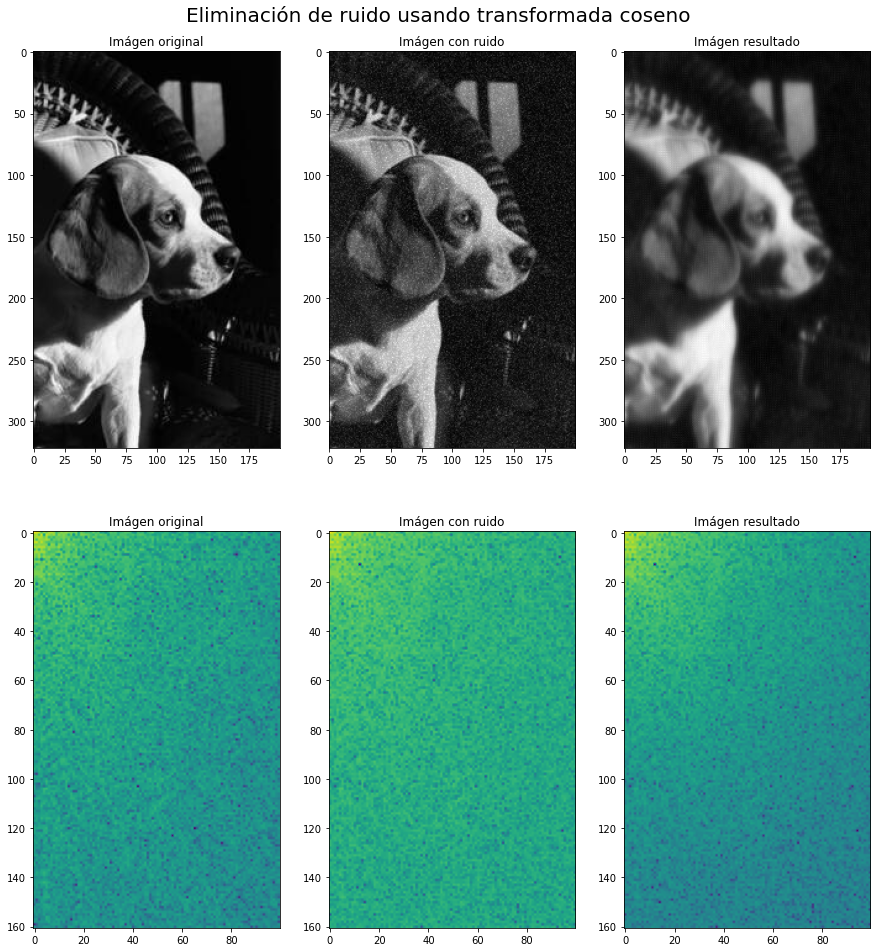

In [765]:
clean = img1
noisy = img1n
denoised = denoise(noisy, "dct", 0.2)

size=15

plt.figure(1,figsize=[size, size])
plt.subplot(231).imshow(clean, cmap=plt.cm.gray)
plt.title("Imágen original")
plt.subplot(232).imshow(noisy, cmap=plt.cm.gray)
plt.title("Imágen con ruido")
plt.subplot(233).imshow(denoised, cmap=plt.cm.gray)
plt.title("Imágen resultado")

cleanT = dct2(clean)
noisyT = dct2(noisy)
denoisedT = dct2(denoised)

plt.subplot(234).imshow(np.log(np.abs(powerSpec(cleanT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen original")
plt.subplot(235).imshow(np.log(np.abs(powerSpec(noisyT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen con ruido")
plt.subplot(236).imshow(np.log(np.abs(powerSpec(denoisedT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen resultado")
plt.suptitle("Eliminación de ruido usando transformada coseno", fontsize=20)
plt.subplots_adjust(top=0.94)

La eliminación de ruido usando la transformada seno presenta un resultado similar a la del coseno con la diferencia de que la del coseno es un poco más oscura.

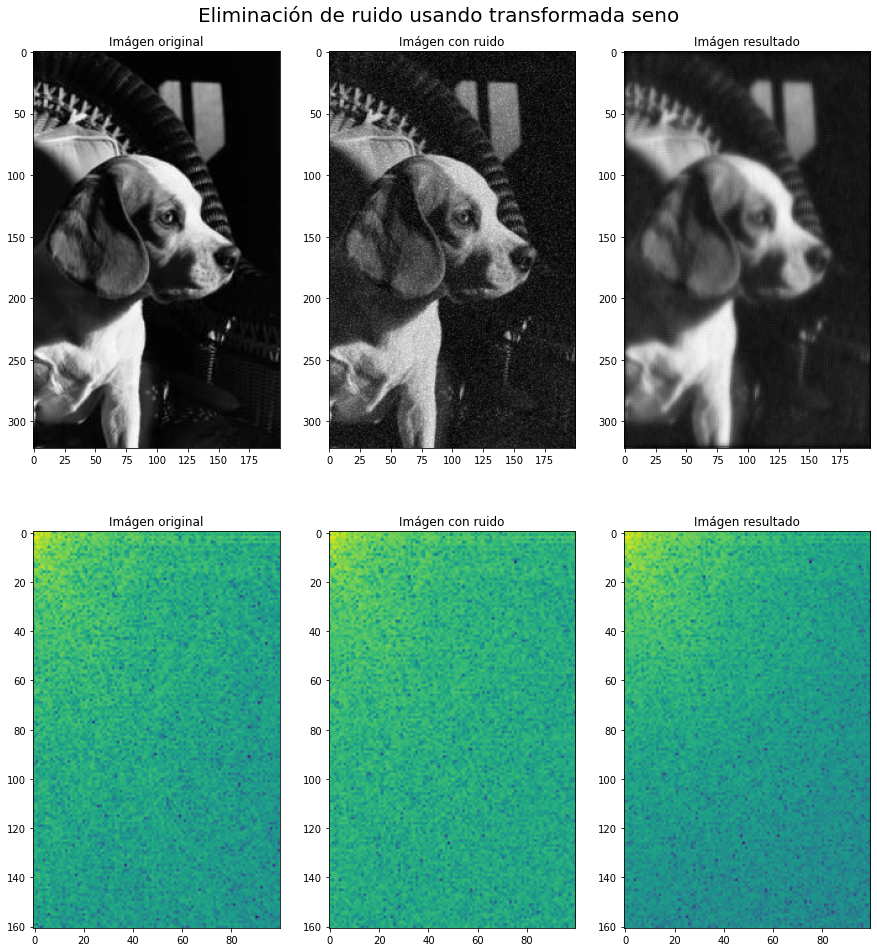

In [769]:
clean = img1
noisy = img1n
denoised = denoise(noisy, "dst", 0.25)

size=15

plt.figure(1,figsize=[size, size])
plt.subplot(231).imshow(clean, cmap=plt.cm.gray)
plt.title("Imágen original")
plt.subplot(232).imshow(noisy, cmap=plt.cm.gray)
plt.title("Imágen con ruido")
plt.subplot(233).imshow(denoised, cmap=plt.cm.gray)
plt.title("Imágen resultado")

cleanT = dst2(clean)
noisyT = dst2(noisy)
denoisedT = dst2(denoised)

plt.subplot(234).imshow(np.log(np.abs(powerSpec(cleanT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen original")
plt.subplot(235).imshow(np.log(np.abs(powerSpec(noisyT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen con ruido")
plt.subplot(236).imshow(np.log(np.abs(powerSpec(denoisedT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen resultado")
plt.suptitle("Eliminación de ruido usando transformada seno", fontsize=20)
plt.subplots_adjust(top=0.94)

Al usar la función con la imágen real se obtienen las imágenes mostradas a continuación, se muestra la imágen original, la imágen con ruido y el resultado de la eliminación del ruido, cada una con su respectivo espectro de potencia. Se puede ver como la mayor parte del ruido es eliminada, pero el resultado es una imagen borrosa y se pierde una gran parte de los detalles.

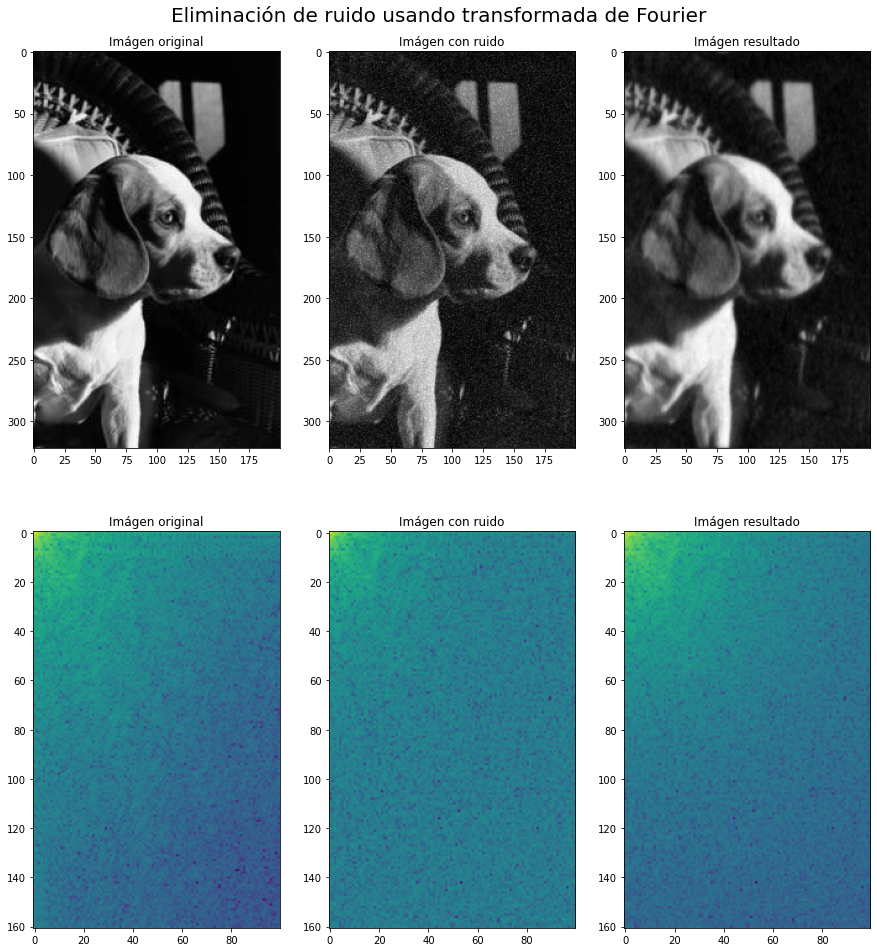

In [770]:
clean = img1
noisy = img1n
denoised = denoise(noisy, "fft", 0.2)

size=15

plt.figure(1,figsize=[size, size])
plt.subplot(231).imshow(clean, cmap=plt.cm.gray)
plt.title("Imágen original")
plt.subplot(232).imshow(noisy, cmap=plt.cm.gray)
plt.title("Imágen con ruido")
plt.subplot(233).imshow(denoised, cmap=plt.cm.gray)
plt.title("Imágen resultado")

cleanT = np.fft.fft2(clean)
noisyT = np.fft.fft2(noisy)
denoisedT = np.fft.fft2(denoised)

plt.subplot(234).imshow(np.log(np.abs(powerSpec(cleanT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen original")
plt.subplot(235).imshow(np.log(np.abs(powerSpec(noisyT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen con ruido")
plt.subplot(236).imshow(np.log(np.abs(powerSpec(denoisedT)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen resultado")
plt.suptitle("Eliminación de ruido usando transformada de Fourier", fontsize=20)
plt.subplots_adjust(top=0.94)

Se usó la función de eliminación de ruido con la transformada onditas, la imágen resultado se ve algo pixelada pero a diferencia de las demás elimina completamente el ruido sin que el resultado sea una imágen borrosa, además al eliminarlo también retira los detalles de la fotografía.

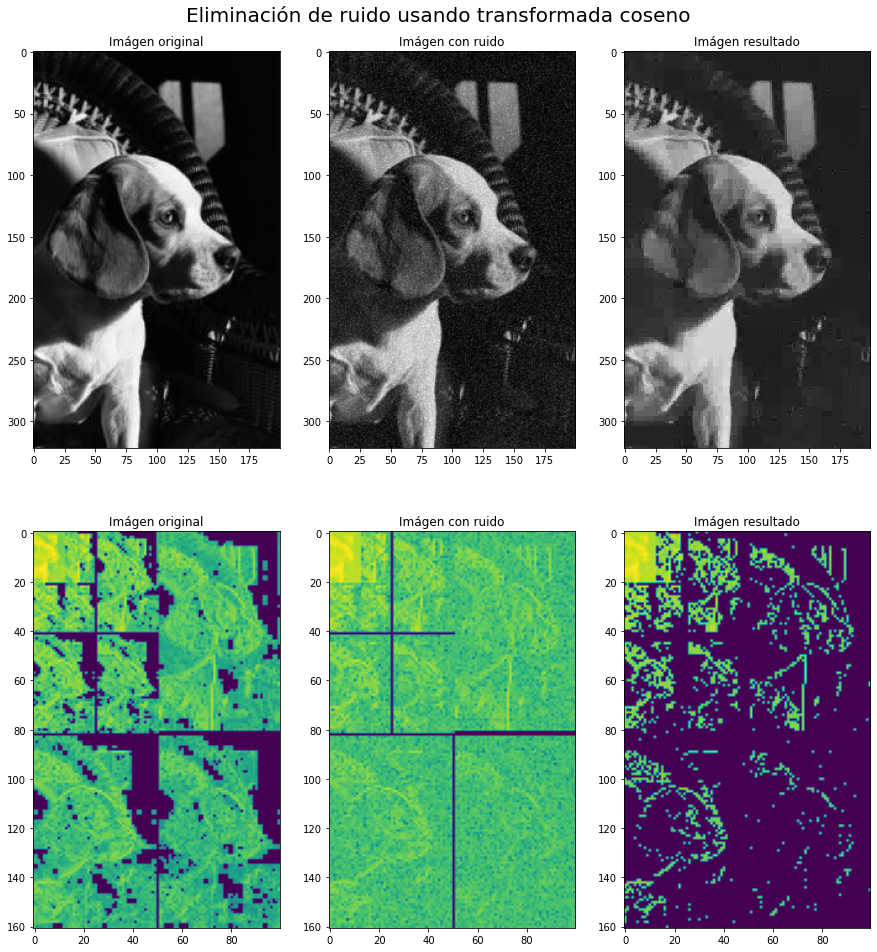

In [773]:
clean = img1
noisy = img1n
denoised = denoise(noisy, "dwt", 0.2)

size=15

plt.figure(1,figsize=[size, size])
plt.subplot(231).imshow(clean, cmap=plt.cm.gray)
plt.title("Imágen original")
plt.subplot(232).imshow(noisy, cmap=plt.cm.gray)
plt.title("Imágen con ruido")
plt.subplot(233).imshow(denoised, cmap=plt.cm.gray)
plt.title("Imágen resultado")


coeffs1 = pywt.wavedec2(clean, wavelet='db1', level=4)
cleanT, coeff_slices1 = pywt.coeffs_to_array(coeffs1)
coeffs1 = pywt.wavedec2(noisy, wavelet='db1', level=4)
noisyT, coeff_slices2 = pywt.coeffs_to_array(coeffs1)
coeffs1 = pywt.wavedec2(denoised, wavelet='db1', level=4)
denoisedT, coeff_slices3 = pywt.coeffs_to_array(coeffs1)

plt.subplot(234).imshow(np.log(np.abs(powerSpec(cleanT+0.00001)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen original")
plt.subplot(235).imshow(np.log(np.abs(powerSpec(noisyT+0.00001)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen con ruido")
plt.subplot(236).imshow(np.log(np.abs(powerSpec(denoisedT+0.00001)))[:round(clean.shape[0]/2),:round(clean.shape[1]/2)])
plt.title("Imágen resultado")
plt.suptitle("Eliminación de ruido usando transformada coseno", fontsize=20)
plt.subplots_adjust(top=0.94)

Finalmente se realizó la eliminación de ruido en las tres imagenes y se muestra una comparación entre las cuatro transformadas.

Text(0.5, 1.0, 'dwt')

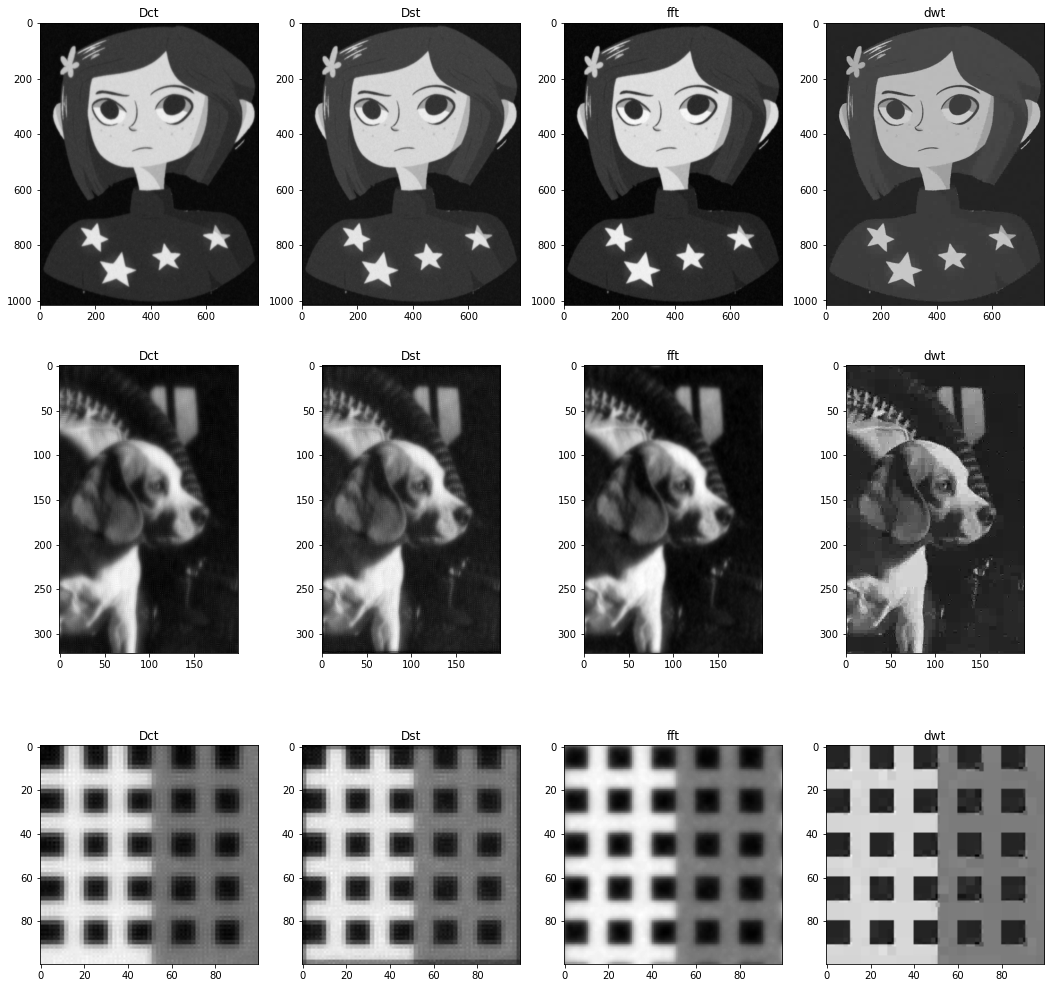

In [782]:
size=18
plt.figure(1,figsize=[size, size])

plt.subplot(341).imshow(denoise(imgn, "dct", 0.2), cmap=plt.cm.gray)
plt.title("Dct")
plt.subplot(342).imshow(denoise(imgn, "dst", 0.25), cmap=plt.cm.gray)
plt.title("Dst")
plt.subplot(343).imshow(denoise(imgn, "fft", 0.12), cmap=plt.cm.gray)
plt.title("fft")
plt.subplot(344).imshow(denoise(imgn, "dwt", 0.2), cmap=plt.cm.gray)
plt.title("dwt")

plt.subplot(345).imshow(denoise(img1n, "dct", 0.2), cmap=plt.cm.gray)
plt.title("Dct")
plt.subplot(346).imshow(denoise(img1n, "dst", 0.25), cmap=plt.cm.gray)
plt.title("Dst")
plt.subplot(347).imshow(denoise(img1n, "fft", 0.12), cmap=plt.cm.gray)
plt.title("fft")
plt.subplot(348).imshow(denoise(img1n, "dwt", 0.2), cmap=plt.cm.gray)
plt.title("dwt")

plt.subplot(349).imshow(denoise(img2n, "dct", 0.2), cmap=plt.cm.gray)
plt.title("Dct")
plt.subplot(3,4,10).imshow(denoise(img2n, "dst", 0.25), cmap=plt.cm.gray)
plt.title("Dst")
plt.subplot(3,4,11).imshow(denoise(img2n, "fft", 0.12), cmap=plt.cm.gray)
plt.title("fft")
plt.subplot(3,4,12).imshow(denoise(img2n, "dwt", 0.2), cmap=plt.cm.gray)
plt.title("dwt")

Se concluye que en cuanto a eliminación de ruido la mejor opción es la transformada onditas ya que no resulta en una imágen borrosa, además la eliminación de ruido tiene mejor resultado en la imágen digital y la sintética ya que no hay detalles que perder, a diferencia de la fotografía donde se ve notablemente afectada la calidad.